# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy import ndimage

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import VGG16
from keras.applications import MobileNetV2

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
project_folder="./Project_data"
train_doc = np.random.permutation(open(project_folder+'/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder+'/val.csv').readlines())
batch_size = 20 # experiment with the batch size
row = 120
col = 120
channel = 3
frames_to_consider_start = 0
frames_to_consider_end = 30
train_path = project_folder + '/' + 'train'
val_path =  project_folder + '/' + 'val'
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
no_of_classes = 5
curr_dt_time = datetime.datetime.now()
num_epochs = 15

### utility function

In [5]:
def normalize_image(img):
    '''this function is used to normalize the image'''
    return ((img-np.min(img))/(np.max(img) - np.min(img)))

def plot_graph(model_history):
    # fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
    plt.plot(model_history.history['categorical_accuracy'])   
    plt.plot(model_history.history['val_categorical_accuracy'])
    plt.legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
c = 3
image_index = [x for x in range(frames_to_consider_start, frames_to_consider_end, 2)] #create a list of image numbers you want to use for a particular video
def generator(source_path, folder_list, batch_size, augment_data=False):
    x = len(image_index)
    y = 120
    z = 120
    
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = batch_data
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_temp = resize(image, (row, col))
                    image_norm = normalize_image(image_temp)
                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2]#normalise and feed in the image
                    if augment_data:
                        rotated_image = ndimage.rotate(image_norm, 10)
                        rotated_image = resize(rotated_image,(row,col))
                        batch_data_aug[folder,idx,:,:,0] = rotated_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rotated_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rotated_image[:,:,2]
                
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if augment_data:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,c)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_aug = batch_data
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_temp = resize(image,(row,col))
                    norm_img = normalize_image(image_temp)
                    
                    batch_data[folder,idx,:,:,0] = (norm_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (norm_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (norm_img[:,:,2])
                    if augment_data:
                        rotated_image = ndimage.rotate(norm_img, 10)
                        rotated_image = resize(rotated_image,(row,col))
                        batch_data_aug[folder,idx,:,:,0] = rotated_image[:,:,0]
                        batch_data_aug[folder,idx,:,:,1] = rotated_image[:,:,1]
                        batch_data_aug[folder,idx,:,:,2] = rotated_image[:,:,2]

                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if augment_data:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels

In [7]:
def train_model(model, train_path, train_doc, val_path, val_doc, batch_size, num_epochs, augment_data=False):
        train_generator = generator(train_path, train_doc,batch_size, augment_data=augment_data)
        val_generator = generator(val_path, val_doc, batch_size, augment_data=augment_data)
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
input_size = (len(image_index), 120,120,channel)

### Model-1 --  model with Conv3d layers
Model with Conv3d layers without batch normalization after convolution layer and using batch normalization after dense layer

In [9]:
#write your model here
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, kernel_size=(3,3,3),input_shape=input_size, padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_conv3d.add(Flatten())
model_conv3d.add(Dense(64,activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))

model_conv3d.add(Dense(64,activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))


model_conv3d.add(Dense(no_of_classes,activation='softmax'))

optimiser = Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 30, 30, 64)     55360     
__________

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
## without augmentation 
model_conv3d_history = train_model(model_conv3d,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs)

Source path = Source path =  ./Project_data/train ; batch size = 20
 ./Project_data/val ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 164s 5s/step - loss: 1.7297 - categorical_accuracy: 0.3576 - val_loss: 6.9404 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-11-0116_17_40.971969/model-00001-1.74567-0.34992-6.94043-0.23000.h5
Epoch 2/15
34/34 [==============================] - 18s 521ms/step - loss: 2.1582 - categorical_accuracy: 0.2843 - val_loss: 7.0247 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-11-0116_17_40.971969/model-00002-2.15818-0.28431-7.02469-0.26000.h5
Epoch 3/15
34/34 [==============================] - 18s 516ms/step - loss: 1.9276 - categorical_accuracy: 0.2549 - val_loss: 4.9014 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2020-11-0116_17_40.971969/model-00003-1.92765-0.25490-4.90137-0.24000.h5
Epoch 4/15
34/34 [==============================] - 21s 609ms/step - loss: 1.7299 - categorical_accuracy: 0.2549 - val_loss: 6.6759 - val_categorical_accuracy: 0.2300

Ep

In [11]:
print("mean of training accuracy is %s" %(np.mean(model_conv3d_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_conv3d_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.2952237380725646
mean of validation accuracy is 0.24733333731691046


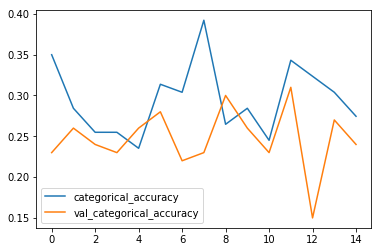

In [12]:
plot_graph(model_conv3d_history)

In [13]:
### model1 with data augmentation
model_conv3d_history = train_model(model_conv3d,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs,augment_data=True)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 199s 6s/step - loss: 1.5966 - categorical_accuracy: 0.3212 - val_loss: 5.7273 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-11-0116_24_34.309379/model-00001-1.58210-0.32504-5.72735-0.23000.h5
Epoch 2/15
34/34 [==============================] - 36s 1s/step - loss: 1.6551 - categorical_accuracy: 0.2451 - val_loss: 4.0949 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-11-0116_24_34.309379/model-00002-1.65514-0.24510-4.09494-0.23000.h5
Epoch 3/15
34/34 [==============================] - 37s 1s/step - loss: 1.7316 - categorical_accuracy: 0.3088 - val_loss: 3.0433 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-11-0116_24_34.309379/model-00003-1.73158-0.30882-3.04328-0.23000.h5
Epoch 4/15
34/34 [==============================] - 36s 1s/step - loss: 1.6067 - categorical_accuracy: 0.3725 - val_loss: 2.3488 - val_categorical_accuracy: 0.2400

Epoch 00004

In [14]:
print("mean of training accuracy is %s" %(np.mean(model_conv3d_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_conv3d_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.3010809497888091
mean of validation accuracy is 0.2573333365221819


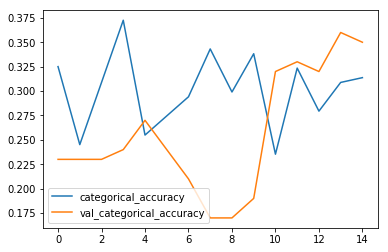

In [15]:
plot_graph(model_conv3d_history)

### Model-2 --  Conv3d layers and batch normalization
Model with conv3d layers and using batch normalization layers after every conv3d layers and using dropout layers

In [16]:
#write your model here
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, kernel_size=(3,3,3),input_shape=input_size, padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(BatchNormalization())

model_conv3d.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(BatchNormalization())

model_conv3d.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(BatchNormalization())

model_conv3d.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())

model_conv3d.add(Flatten())
model_conv3d.add(Dense(64,activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))

model_conv3d.add(Dense(64,activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))


model_conv3d.add(Dense(no_of_classes,activation='softmax'))

optimiser = Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 60, 60, 16)     64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 3, 30, 30, 32)     0         
__________

In [17]:
model_conv3d_history = train_model(model_conv3d,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs, augment_data=True)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/trainEpoch 1/15 ; batch size = 20



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 197s 6s/step - loss: 1.6037 - categorical_accuracy: 0.3819 - val_loss: 7.7543 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-11-0116_36_34.618482/model-00001-1.59053-0.39140-7.75434-0.26000.h5
Epoch 2/15
34/34 [==============================] - 36s 1s/step - loss: 1.7905 - categorical_accuracy: 0.3333 - val_loss: 8.5337 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2020-11-0116_36_34.618482/model-00002-1.79045-0.33333-8.53367-0.28000.h5
Epoch 3/15
34/34 [==============================] - 36s 1s/step - loss: 2.2196 - categorical_accuracy: 0.2108 - val_loss: 4.8478 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-11-0116_36_34.618482/model-00003-2.21962-0.21078-4.84775-0.23000.h5
Epoch 4/15
34/34 [==============================] - 37s 1s/step - loss: 1.8949 - categorical_accuracy: 0.2892 - val_loss: 9.2806 - val_categorical_accuracy: 0.3000

Epoch 00004

In [18]:
print("mean of training accuracy is %s" %(np.mean(model_conv3d_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_conv3d_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.3143288135693384
mean of validation accuracy is 0.33000000208616254


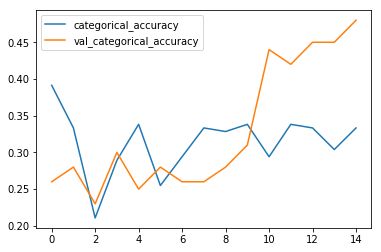

In [19]:
plot_graph(model_conv3d_history)

### Model-3 --  Conv3d layers without batchnormalization layer and dropout layer
Model with only conv3d layers

In [20]:
#write your model here
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, kernel_size=(3,3,3),input_shape=input_size, padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model_conv3d.add(Flatten())
model_conv3d.add(Dense(no_of_classes,activation='softmax'))

optimiser = Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 3, 30, 30, 64)     55360     
__________

In [21]:
model_conv3d_history = train_model(model_conv3d,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs,augment_data=True)

Source path = Source path =  ./Project_data/train ; batch size = 20
 ./Project_data/val ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 190s 6s/step - loss: 1.6090 - categorical_accuracy: 0.2068 - val_loss: 1.5477 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2020-11-0116_48_35.925639/model-00001-1.60652-0.20362-1.54775-0.17000.h5
Epoch 2/15
34/34 [==============================] - 35s 1s/step - loss: 1.6140 - categorical_accuracy: 0.1667 - val_loss: 1.6115 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-11-0116_48_35.925639/model-00002-1.61397-0.16667-1.61148-0.21000.h5
Epoch 3/15
34/34 [==============================] - 36s 1s/step - loss: 1.6089 - categorical_accuracy: 0.1765 - val_loss: 1.6106 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2020-11-0116_48_35.925639/model-00003-1.60895-0.17647-1.61058-0.16000.h5
Epoch 4/15
34/34 [==============================] - 37s 1s/step - loss: 1.6124 - categorical_accuracy: 0.1863 - val_loss: 1.6083 - val_categorical_accuracy: 0.2200

Epoch 00004

In [22]:
print("mean of training accuracy is %s" %(np.mean(model_conv3d_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_conv3d_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.2606334910343615
mean of validation accuracy is 0.2900000017384688


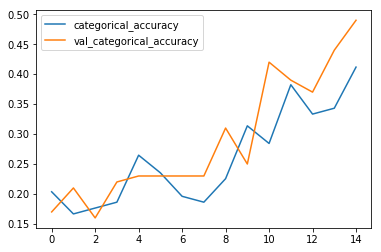

In [23]:
plot_graph(model_conv3d_history)

### Model-4 -- transfer learning with VGG16 and LSTM

using existing model VGG16 with RNN model (LSTM)

In [24]:
vgg16_transfer = VGG16(weights="imagenet", include_top=False)
model_vgg16 = Sequential()
model_vgg16.add(TimeDistributed(vgg16_transfer, input_shape=input_size))
for layer in model_vgg16.layers:
    layer.trainable = False
model_vgg16.add(TimeDistributed(BatchNormalization()))
model_vgg16.add(TimeDistributed(MaxPooling2D((2, 2))))
model_vgg16.add(TimeDistributed(Flatten()))

model_vgg16.add(LSTM(128))
model_vgg16.add(Dropout(0.5))

model_vgg16.add(Dense(128,activation='relu'))
model_vgg16.add(Dropout(0.25))

model_vgg16.add(Dense(no_of_classes, activation='softmax'))


optimiser = optimizers.Adam()
model_vgg16.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_vgg16.summary())

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (De

In [25]:
model_vgg16_history = train_model(model_vgg16,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs, augment_data=True)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 221s 6s/step - loss: 1.5998 - categorical_accuracy: 0.2804 - val_loss: 1.4487 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-11-0117_00_34.946142/model-00001-1.61300-0.26244-1.44867-0.42000.h5
Epoch 2/15
34/34 [==============================] - 36s 1s/step - loss: 1.4687 - categorical_accuracy: 0.4069 - val_loss: 1.3621 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-11-0117_00_34.946142/model-00002-1.46870-0.40686-1.36212-0.46000.h5
Epoch 3/15
34/34 [==============================] - 39s 1s/step - loss: 1.5464 - categorical_accuracy: 0.3480 - val_loss: 1.3521 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-11-0117_00_34.946142/model-00003-1.54641-0.34804-1.35213-0.49000.h5
Epoch 4/15
34/34 [==============================] - 39s 1s/step - loss: 1.4225 - categorical_accuracy: 0.4020 - val_loss: 1.2498 - val_categorical_accuracy: 0.5600

Epoch 00004

In [37]:
print("mean of training accuracy is %s" %(np.mean(model_vgg16_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_vgg16_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.427953750256949
mean of validation accuracy is 0.5060000038146972


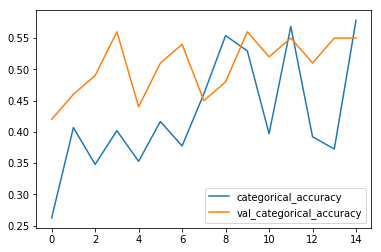

In [27]:
plot_graph(model_vgg16_history)

### Model-5 -- transfer learning with VGG16 and GRU
using existing predefined model VGG16 with RNN (GRU)

In [28]:
model_gru = Sequential()
model_gru.add(TimeDistributed(vgg16_transfer, input_shape=input_size))
for layer in model_gru.layers:
    layer.trainable = False
model_gru.add(TimeDistributed(BatchNormalization()))
model_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru.add(TimeDistributed(Flatten()))

model_gru.add(GRU(128))
model_gru.add(Dropout(0.5))

model_gru.add(Dense(128,activation='relu'))
model_gru.add(Dropout(0.25))

model_gru.add(Dense(no_of_classes, activation='softmax'))


optimiser = optimizers.Adam()
model_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 3, 3, 512)     2048      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 512)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               246144    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
__________

In [29]:
model_gru_history = train_model(model_gru,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs, augment_data=True)

Source path =  ./Project_data/val ; batch size = 20
Source path =  Epoch 1/15./Project_data/train ; batch size = 20



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 215s 6s/step - loss: 1.7399 - categorical_accuracy: 0.2748 - val_loss: 1.3428 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-11-0117_13_29.308065/model-00001-1.75658-0.26923-1.34276-0.46000.h5
Epoch 2/15
34/34 [==============================] - 36s 1s/step - loss: 1.4417 - categorical_accuracy: 0.3578 - val_loss: 1.4043 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-11-0117_13_29.308065/model-00002-1.44174-0.35784-1.40427-0.40000.h5
Epoch 3/15
34/34 [==============================] - 39s 1s/step - loss: 1.4046 - categorical_accuracy: 0.4069 - val_loss: 1.2884 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-11-0117_13_29.308065/model-00003-1.40464-0.40686-1.28838-0.41000.h5
Epoch 4/15
34/34 [==============================] - 38s 1s/step - loss: 1.3667 - categorical_accuracy: 0.4167 - val_loss: 1.2904 - val_categorical_accuracy: 0.4600

Epoch 00004

In [36]:
print("mean of training accuracy is %s" %(np.mean(model_gru_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_gru_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.4699095075516439
mean of validation accuracy is 0.5266666660706202


This model is the best in terms of accuracy for training and validation and its accuracy can be increased more if <br>
we increase the number of epocs

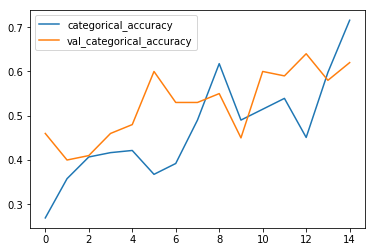

In [31]:
plot_graph(model_gru_history)

### Model-6 -- transfer learning with MobileNetV2
using existing model MobileNetV2 with RNN (GRU)

In [32]:
mobilenet_transfer = MobileNetV2(weights='imagenet', include_top=False)
model_mobilenet = Sequential()
model_mobilenet.add(TimeDistributed(mobilenet_transfer,input_shape=input_size))
for layer in model_mobilenet.layers:
    layer.trainable = False

model_mobilenet.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mobilenet.add(TimeDistributed(Flatten()))

model_mobilenet.add(GRU(128))
model_mobilenet.add(Dropout(0.25))

model_mobilenet.add(Dense(128,activation='relu'))
model_mobilenet.add(Dropout(0.25))

model_mobilenet.add(Dense(no_of_classes, activation='softmax'))

optimiser = optimizers.Adam()
model_mobilenet.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_mobilenet.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:310: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 5120)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (D

In [33]:
model_mobilenet_history = train_model(model_mobilenet,train_path,train_doc,val_path,val_doc,batch_size, num_epochs=num_epochs, augment_data=True)

Source path = Source path =  ./Project_data/train ; batch size = 20
 ./Project_data/val ; batch size = 20
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 193s 6s/step - loss: 1.6788 - categorical_accuracy: 0.2689 - val_loss: 1.5743 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-11-0117_26_31.455820/model-00001-1.68679-0.27149-1.57432-0.24000.h5
Epoch 2/15
34/34 [==============================] - 34s 992ms/step - loss: 1.6058 - categorical_accuracy: 0.2794 - val_loss: 1.6171 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2020-11-0117_26_31.455820/model-00002-1.60579-0.27941-1.61710-0.24000.h5
Epoch 3/15
34/34 [==============================] - 36s 1s/step - loss: 1.7107 - categorical_accuracy: 0.2549 - val_loss: 1.7799 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-11-0117_26_31.455820/model-00003-1.71073-0.25490-1.77988-0.21000.h5
Epoch 4/15
34/34 [==============================] - 39s 1s/step - loss: 1.7116 - categorical_accuracy: 0.2304 - val_loss: 1.6875 - val_categorical_accuracy: 0.2200

Epoch 00

In [34]:
print("mean of training accuracy is %s" %(np.mean(model_conv3d_history.history['categorical_accuracy'])))
print("mean of validation accuracy is %s" %(np.mean(model_conv3d_history.history['val_categorical_accuracy'])))

mean of training accuracy is 0.2606334910343615
mean of validation accuracy is 0.2900000017384688


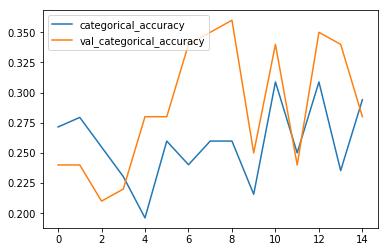

In [35]:
plot_graph(model_mobilenet_history)

### Loading model and testing 

In [38]:
import time
from keras.models import load_model

In [39]:
model = load_model('model-00015-0.78444-0.71569-1.00037-0.62000.h5')

In [42]:
data = generator(val_path,val_doc,batch_size)
batch_data, batch_labels = next(data)

Source path =  ./Project_data/val ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))